# <font color='blue'>Projeto 2 - Teste A/B</font>
## <font color='blue'>Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?</font>

In [2]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

<Figure size 1500x600 with 0 Axes>

## Carregando e Compreendendo os Dados

Variante A: Mostra o número atual de comentários e avaliações de usuários.

Variante B: Não mostra os comentários de usuários no site.

In [3]:
# Carrega o dataset
df_vendas = pd.read_csv('data/dataset2.csv')

In [4]:
# Visualiza os dados
df_vendas.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


In [5]:
# Visualiza 
df_vendas.tail()

,id,variante,compra,data
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09
54999,0x983331,A,False,2019-09-05


## Análise Exploratória e Cálculo de Probabilidade

In [6]:
# Shape dos dados
df_vendas.shape

(55000, 4)

In [7]:
# Tipos de dados
df_vendas.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

In [8]:
# Data máxima
df_vendas['data'].max()

'2020-01-30'

In [9]:
# Data mínima
df_vendas['data'].min()

'2019-01-01'

In [10]:
# Checando valores nulos
df_vendas.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [13]:
# Checando se tem IDs duplicados
df_vendas.id.value_counts().count()

55000

In [14]:
# Proporção do resultado de conversão
df_vendas.compra.value_counts()

compra
False    46416
True      8584
Name: count, dtype: int64

In [15]:
# Proporção das variantes mostradas aos usuários
df_vendas.variante.value_counts()

variante
A    50000
B     5000
Name: count, dtype: int64

Calculando probabilidades básicas.

**Variante A é o grupo de controle. Variante B é o grupo de teste ou tratamento.**

In [16]:
# Probabilidade de um usuário visualizar a variante A
df_vendas[df_vendas.variante == 'A'].shape[0] / df_vendas.shape[0] * 100

90.9090909090909

In [17]:
# Probabilidade de um usuário visualizar qualquer variante
df_vendas.shape[0] / df_vendas.shape[0] * 100

100.0

In [19]:
# Probabilidade de um usuário visualizar a variante B
df_vendas[df_vendas.variante == 'B'].shape[0] / df_vendas.shape[0] * 100

9.090909090909092

In [20]:
# Total de compras realizadas (conversões)
df_vendas.compra.sum()

8584

In [21]:
# Total de compras realizadas quando a variante era A
df_vendas[df_vendas.variante == 'A'].compra.sum()

7603

In [22]:
# Total de compras realizadas quando a variante era B
df_vendas[df_vendas.variante == 'B'].compra.sum()

981

In [23]:
# Probabilidade de conversão independente da variante recebida
df_vendas.compra.mean()

0.15607272727272728

In [24]:
# Dado que um indivíduo estava no grupo de controle, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'A'].compra.mean()

0.15206

In [25]:
# Dado que um indivíduo estava no grupo de tratamento, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'B'].compra.mean()

0.1962

A probabilidade de receber a nova página é de aproximadamente 10% e a probabilidade total de conversão é de 19%. Precisamos checar se temos evidências suficientes para dizer que o grupo de tratamento leva a um aumento das conversões.

## Tarefa 1 - Configurando o Experimento

Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?

Variante A: Mostra o número atual de comentários e avaliações de usuários

Variante B: Não mostra os comentários de usuários no site

Observe que, devido ao registro de data e hora associado a cada evento, você pode tecnicamente executar um teste de hipótese continuamente à medida que cada evento é observado.

No entanto, a questão difícil é saber quando parar assim que uma variante for considerada significativamente melhor do que outra ou isso precisa acontecer de forma consistente por um determinado período de tempo? Quanto tempo até você decidir que nenhuma variante é melhor que a outra? Converse com a área de negócio para definir a melhor abordagem para o teste e apresentaremos algumas dicas durante este trabalho.

Essas questões são as partes mais difíceis associadas aos Testes A/B e a análise em geral.

Por enquanto, considere que você precisa tomar uma decisão apenas com base nos dados fornecidos. Se você quiser assumir que a variante A é melhor, a menos que a nova variante prove ser definitivamente melhor em uma taxa de erro Tipo I de 5%, quais deveriam ser suas hipóteses nula e alternativa? 

Você pode definir suas hipóteses em termos de palavras ou em notação como $p_{A}$ e $p_{B}$, que são as probabilidades de conversão para as variantes nova e antiga.

- H0: PB - PA = 0
- H1: PB - PA > 0

H0 nos diz que a diferença de probabilidade dos dois grupos é igual a zero.

H1 nos diz que a diferença de probabilidade dos dois grupos é maior do que zero.

### Pré-Processamento dos Dados

Faremos alguns cálculos pesados e para simplificar o processo, iremos filtrar os dados e usar apenas um dos meses.

In [28]:
# Função para extrair ano e mês da data
def extrai_data(x):
    return x[:7]

In [30]:
# Extrai ano e mês da coluna de data
df_vendas['ano_mes'] = df_vendas['data'].apply(extrai_data)

# Visualiza
df_vendas.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [32]:
# Trabalhando apenas com os dados de Janeiro/2020 para simplificar o processo 
df_vendas_2020 = df_vendas[df_vendas['ano_mes'] == '2020-01']

# Visualiza
df_vendas_2020.head()


,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


In [33]:
# shape
df_vendas_2020.shape

(8821, 5)

### Criação do Baseline

Vamos criar um baseline (linha base) da taxa de conversão antes de executar o teste de hipótese. Assim, saberemos a taxa de conversão base e o aumento desejado em compras que gostaríamos de testar.

* A será o grupo de controle 
* B será o grupo de teste

In [34]:
# Gerando um dataframe
df_ab_data = df_vendas_2020[['variante', 'compra']]
df_ab_data.head()

,variante,compra
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [35]:
# Shape
df_ab_data.shape

(8821, 2)

In [38]:
# Altera o nome das colunas
df_ab_data.columns = ['grupo', 'conversao']

# Visualiza
df_ab_data.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [40]:
# Tabela pivot para o sumário dos dados
df_ab_sumario = df_ab_data.pivot_table(values='conversao', index='grupo', aggfunc=np.sum)
# Visualiza os dados
df_ab_sumario.head()

C:\Users\moise\AppData\Local\Temp\ipykernel_17576\1344559272.py:2: FutureWarning: The provided callable <function sum at 0x00000132643BD080> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_ab_sumario = df_ab_data.pivot_table(values='conversao', index='grupo', aggfunc=np.sum)


,conversao
grupo,
A,587
B,981


In [42]:
# Sumário com total 
df_ab_sumario['total'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x: len(x))
# Visualiza os dados
df_ab_sumario.head()

,conversao,total
grupo,,
A,587,3821
B,981,5000


In [44]:
# Sumário com taxa
df_ab_sumario['taxa'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo')
# Visualiza os dados
df_ab_sumario.head()

,conversao,total,taxa
grupo,,,
A,587,3821,0.153625
B,981,5000,0.196200


In [45]:
# Obtemos os valores da variante A
conversao_A = df_ab_sumario['conversao'][0]
total_A = df_ab_sumario['total'][0]
taxa_A = df_ab_sumario['taxa'][0]

# Obtemos os valores da variante B
conversao_B = df_ab_sumario['conversao'][1]
total_B = df_ab_sumario['total'][1]
taxa_B = df_ab_sumario['taxa'][1]

C:\Users\moise\AppData\Local\Temp\ipykernel_17576\3408572024.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conversao_A = df_ab_sumario['conversao'][0]
C:\Users\moise\AppData\Local\Temp\ipykernel_17576\3408572024.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_A = df_ab_sumario['total'][0]
C:\Users\moise\AppData\Local\Temp\ipykernel_17576\3408572024.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  taxa_A = df_ab_su

Taxa de conversão da linha de base (Baseline conversion rate).

Igual a $p$ no contexto de uma distribuição binomial e $p$ é a probabilidade de sucesso.

In [46]:
# Taxa de conversão da linha de base.
conversao_base = taxa_A
conversao_base

0.15362470557445695

Efeito mínimo detectável (Minimum Detectable Effect).

Às vezes referido como nível de significância prática.

In [47]:
# Efeito mínimo detectável
efeito_minimo = taxa_B - taxa_A
efeito_minimo

0.04257529442554306

## Tarefa 2 - Execução do Teste de Hipóteses

Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

Poder estatístico ou sensibilidade.

Igual a 1 - $\beta$. 

Normalmente 80% é usado para a maioria das análises. É a probabilidade de rejeitar a hipótese nula quando a hipótese nula é de fato falsa.

Parâmetros que usaremos para executar o teste:

1- Alfa (Nível de significância) $\alpha$: normalmente 5%; probabilidade de rejeitar a hipótese nula quando a hipótese nula for verdadeira

2- Beta $\beta$: probabilidade de aceitar a hipótese nula quando a hipótese nula é realmente falsa.

In [50]:
# Parâmetros que usaremos para executar o teste
alfa = 0.05
beta = 0.2

# Tamanho da amostra
n = 50000

Podemos supor que a distribuição de nosso grupo de controle é binomial porque os dados são uma série de tentativas de Bernoulli, em que cada tentativa tem apenas dois resultados possíveis (semelhante a um cara ou coroa).
 
 Para o teste usaremos a função binom() do SciPy:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html

In [51]:
# Teste Binomial (usando padrão de 5% para o nível de significância)
teste_binom = scs.binom(n, p = conversao_base)

In [52]:
help(teste_binom)

Help on rv_discrete_frozen in module scipy.stats._distn_infrastructure object:

class rv_discrete_frozen(rv_frozen)
 |  rv_discrete_frozen(dist, *args, **kwds)
 |  
 |  Method resolution order:
 |      rv_discrete_frozen
 |      rv_frozen
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  logpmf(self, k)
 |  
 |  pmf(self, k)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from rv_frozen:
 |  
 |  __init__(self, dist, *args, **kwds)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, x)
 |  
 |  entropy(self)
 |  
 |  expect(self, func=None, lb=None, ub=None, conditional=False, **kwds)
 |  
 |  interval(self, confidence=None)
 |  
 |  isf(self, q)
 |  
 |  logcdf(self, x)
 |  
 |  logsf(self, x)
 |  
 |  mean(self)
 |  
 |  median(self)
 |  
 |  moment(self, order=None)
 |  
 |  ppf(self, q)
 |  
 |  rvs(self, size=None, random_state=None)
 |  
 |  sf(self, x)
 |  
 |  stats(self, m

In [53]:
# Teste Binomial com o efeito mínimo (no nosso exemplo 0.04 para o nível de significância)
teste_binom_mde = scs.binom(n, p = conversao_base + efeito_minimo)

Agora visualizamos a probability mass function (pmf).

<BarContainer object of 50001 artists>

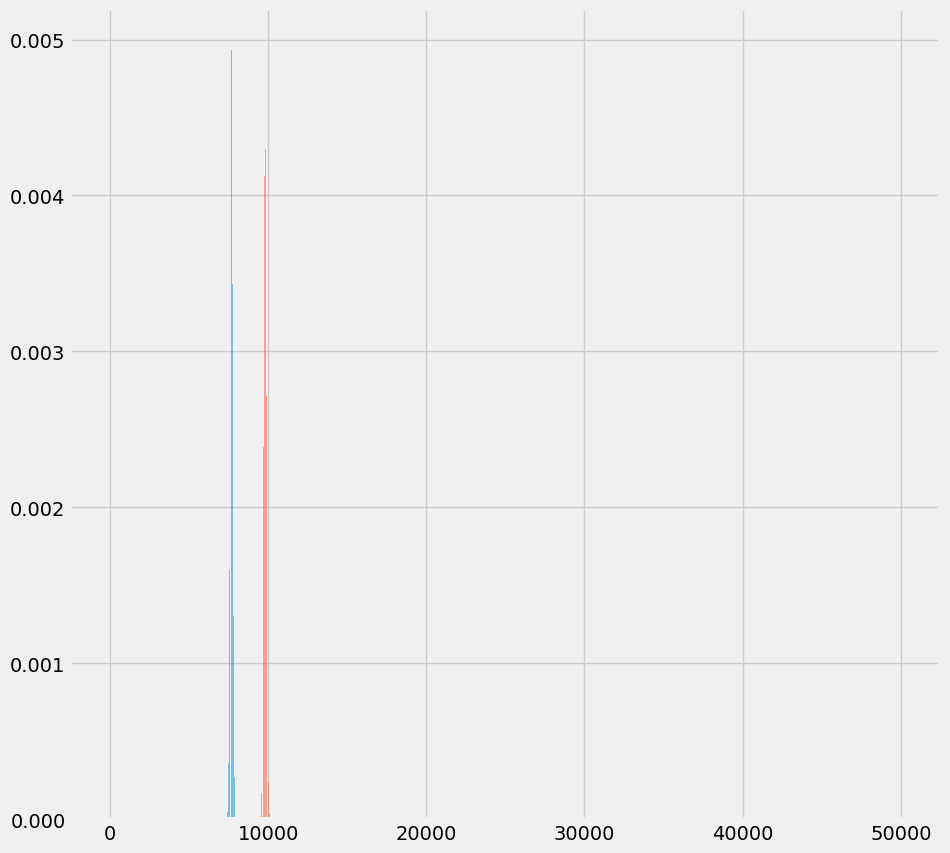

In [54]:
# Plot

# Area de plotagem
fig, ax = plt.subplots(figsize = (10,10))

# definimos diversos valores para X
x = np.linspace(0, int(n), int(n) + 1)

# Plotamos os resultados com a pmf e alfa de 0.5
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

## Tarefa 3 - Plot da Distribuição

Criamos o Plot da distribuição da diferença entre as duas amostras e comparamos os resultados.

Podemos comparar os dois grupos traçando a distribuição do grupo de controle e calculando a probabilidade de obter o resultado de nosso grupo de teste.

Text(0, 0.5, 'Probabilidade')

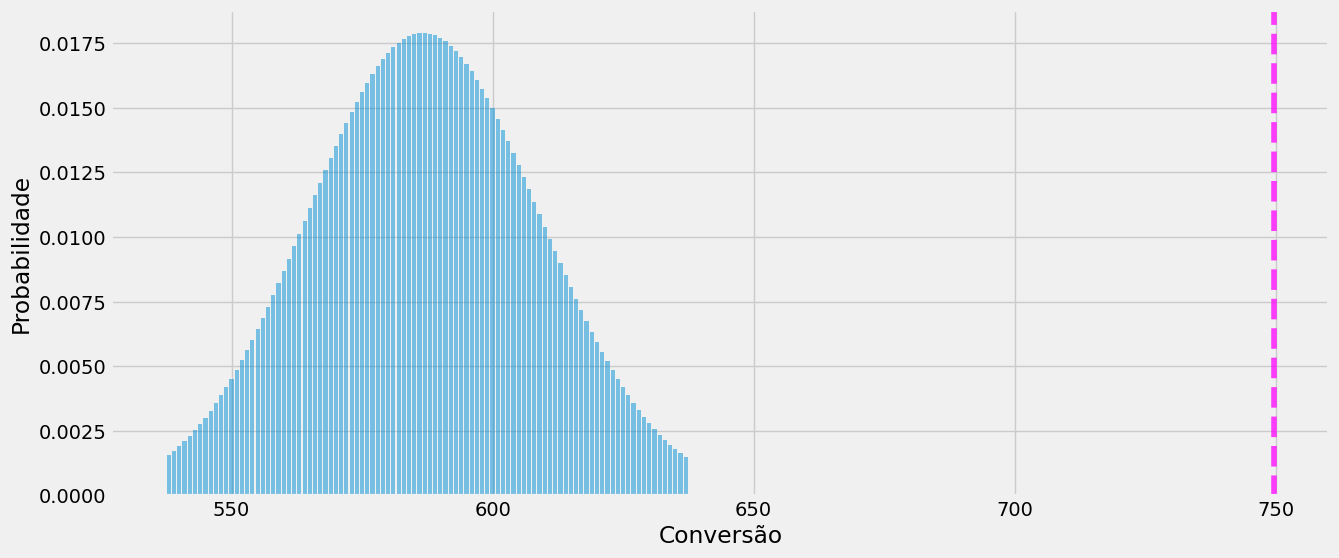

In [56]:
# Plot da distribuição do grupo A (controle)

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Teste de A
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, taxa_A).pmf(x)

# Cria a barra vertical
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = taxa_B * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')


Text(0, 0.5, 'Probabilidade')

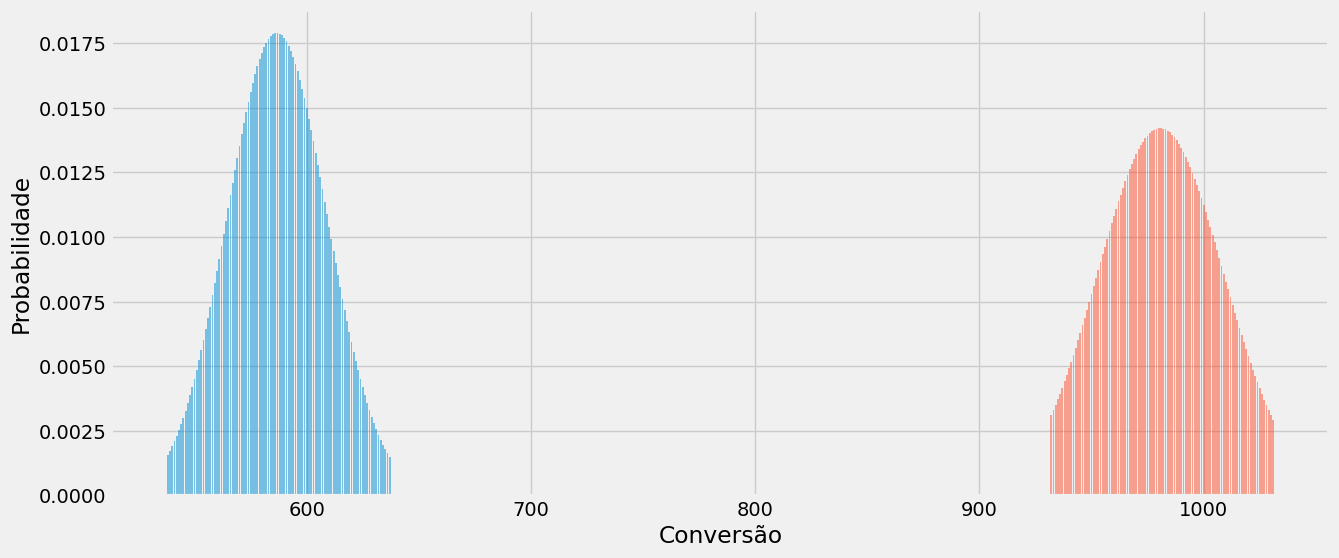

In [57]:
# Plot da distribuição dos 2 grupos

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Podemos ver que o grupo de teste converteu mais usuários do que o grupo de controle. Também podemos ver que o pico dos resultados do grupo de teste é inferior ao do grupo de controle. 

Mas como interpretamos a diferença no pico da probabilidade? 

Devemos nos concentrar, em vez disso, na taxa de conversão para que tenhamos uma comparação de termos equivalentes. Para calcular isso, precisamos padronizar os dados e comparar a probabilidade de sucesso, p, para cada grupo.